# Classification of Fruits

#### Reference:
Tensor Flow Documentation: https://www.tensorflow.org/tutorials/images/classification
Dataset: https://drive.google.com/file/d/10ZFyO9kleZLawHVN0OLeoXFCulkJFDwc/view

#### Hypothesis:
Image processing can help factories filter separate fruits from each other. It can also help separate fresh and rotten fruits from each other.

This hypothesis proposes that by analyzing images of fruits, factories can automatically put different fruits into their respective categories faster. This can lead to more efficient separation of fruits.

### Imports and Constants

In [38]:
#Importing Libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2
import os

In [39]:
#Constant Values
SIZE = 256
BATCH = 32
COLORS = 3
SEED = 935115
EPOCHS = 40

#### Loading Dataset

In [40]:
#Loading the files using keras
fruits_dataset = tf.keras.preprocessing.image_dataset_from_directory('dataset',shuffle=True,batch_size=BATCH,image_size=(SIZE,SIZE),seed=SEED)
# Parameters:
# 'dataset': the directory of the dataset
# shuffle: Shuffles the images so that they are not ordered perfectly
# batch_size: Size of the batches of images that will be applied in the model. In this case each batch contains 32 images
# image_size: Resizes the images to 256,256

Found 1512 files belonging to 6 classes.


Our dataset has 1512 images.

#### Classes in the Dataset

In [41]:
#Listing the classes in the dataset
classes = fruits_dataset.class_names
print(classes)

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


The classes in the dataset are 'freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges'.

#### Display Sample Images

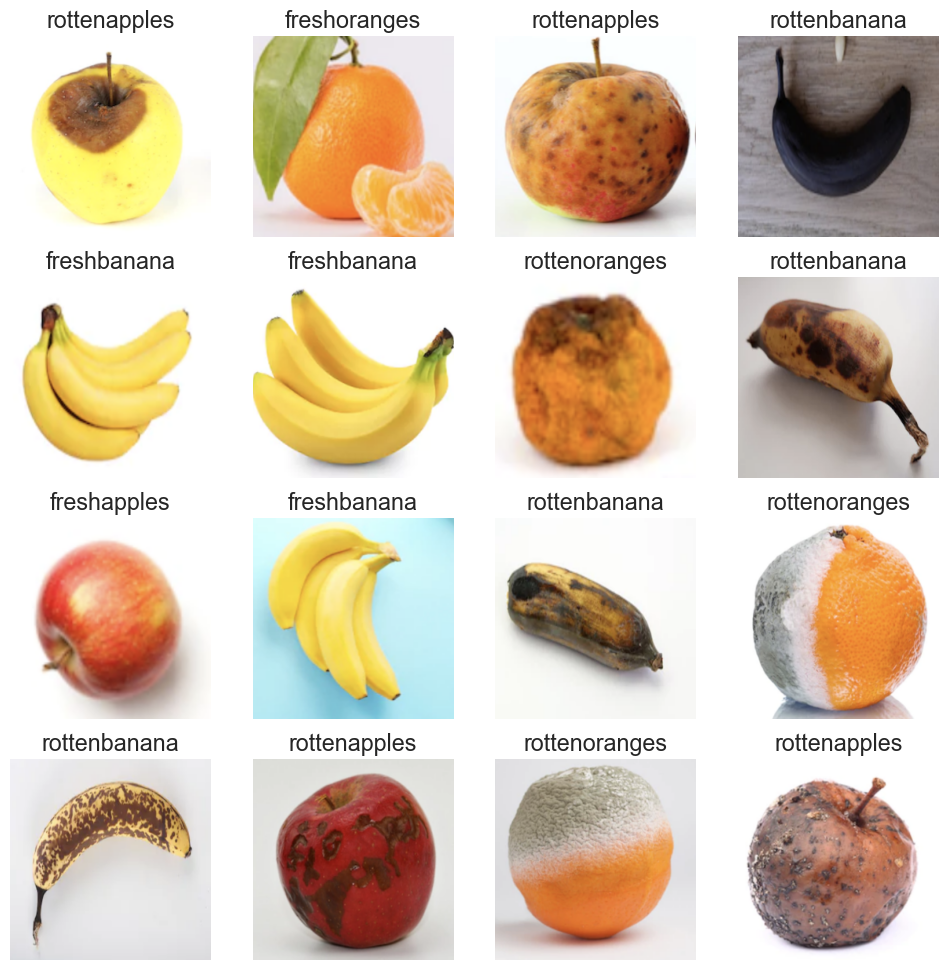

In [42]:
#Show sample of the dataset
plt.figure(figsize=(12,12))
for batch, labels in fruits_dataset.take(1):
    for i in range(int(BATCH/2)):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(batch[i].numpy().astype('uint8'))
        plt.title(classes[labels[i]])
        plt.axis('off')

#### Splitting Dataset to Train, Test, and Validation Sets

- We shall split the dataset into a ratio of 70% train set, 15% validation set, and 15% test split.

In [43]:
#Unable to use sklearn.modelselection.train_test_split
#Custom function will be used to split the dataset into train, validation, and test datasets
def splits(dataset, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=SEED)
    
    train_size = int(train_split * size)
    val_size = int(val_split * size)
    
    train_dataset = dataset.take(train_size)    
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

train, validation, test = splits(fruits_dataset)

#### Configuring Dataset for Performance

In [44]:
#Making the variables load faster, randomize, and give tensorflow the ability to change buffer size
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Creating the model

#### Creating a resizing and rescaling model

In [45]:
#Resizing and rescaling model
resize_and_rescale = tf.keras.Sequential([layers.Resizing(SIZE, SIZE),layers.Rescaling(1.0/255)])

#### Creating an Augmenation Model
This model will flip the images in horizontal and vertical axis as well as give it a random rotation

In [46]:
#Augmenting the data using a data augmentation model
augmentor = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Creating the CNN Model
The model has 6 convolution layers (Conv2D) with a max pooling layer (MaxPooling2D) after each.

In [47]:
shape = (BATCH, SIZE, SIZE, COLORS)
num_of_classes = len(classes)

model = models.Sequential([
    augmentor,
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_of_classes, activation='softmax'),
])

model.build(input_shape=shape)

#### Compiling the Model

In [48]:
#Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### Model Summary

In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Training The Model
The model will be trained for 40 epochs

In [50]:
#Train the model
history = model.fit(
    train,
    batch_size=BATCH,
    validation_data=validation,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
33/33 [==============================] - 55s 1s/step - loss: 1.6593 - accuracy: 0.3043 - val_loss: 1.4336 - val_accuracy: 0.3705
Epoch 2/40
33/33 [==============================] - 41s 1s/step - loss: 1.3708 - accuracy: 0.4254 - val_loss: 1.2856 - val_accuracy: 0.4286
Epoch 3/40
33/33 [==============================] - 43s 1s/step - loss: 1.1634 - accuracy: 0.5339 - val_loss: 1.0198 - val_accuracy: 0.6205
Epoch 4/40
33/33 [==============================] - 43s 1s/step - loss: 0.9059 - accuracy: 0.6395 - val_loss: 0.7746 - val_accuracy: 0.7277
Epoch 5/40
33/33 [==============================] - 44s 1s/step - loss: 0.8509 - accuracy: 0.6657 - val_loss: 0.6628 - val_accuracy: 0.7946
Epoch 6/40
33/33 [==============================] - 44s 1s/step - loss: 0.7200 - accuracy: 0.7132 - val_loss: 0.6853 - val_accuracy: 0.7589
Epoch 7/40
33/33 [==============================] - 44s 1s/step - loss: 0.5889 - accuracy: 0.8014 - val_loss: 0.5612 - val_accuracy: 0.7679
Epoch 8/40
33/33 [==

# Model Evaluation

In [51]:
scores = model.evaluate(test)
print("The model has a final loss of", str(np.round(scores[0]*100,2)) + "%, and an accuracy of",str(np.round(scores[1]*100,2)) + "%")

8/8 [==============================] - 8s 323ms/step - loss: 0.1223 - accuracy: 0.9688
The model has a final loss of 12.23%, and an accuracy of 96.88%


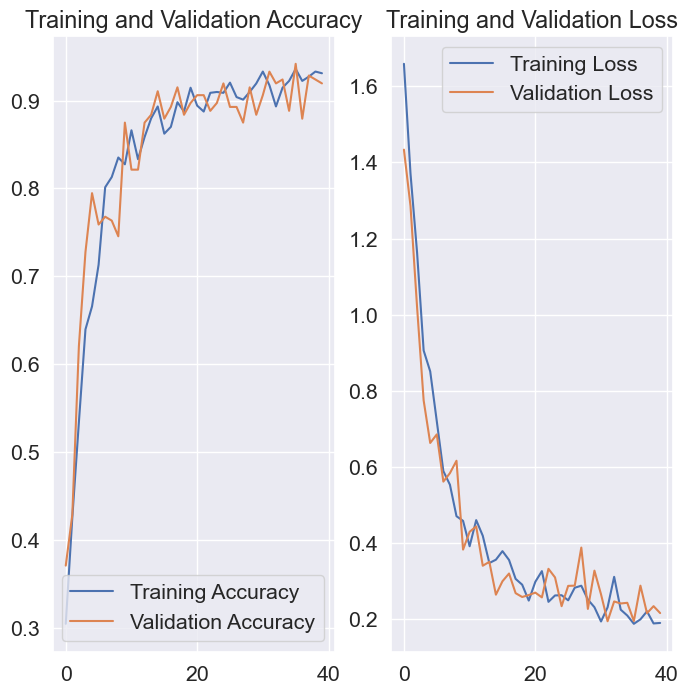

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Displaying Results

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


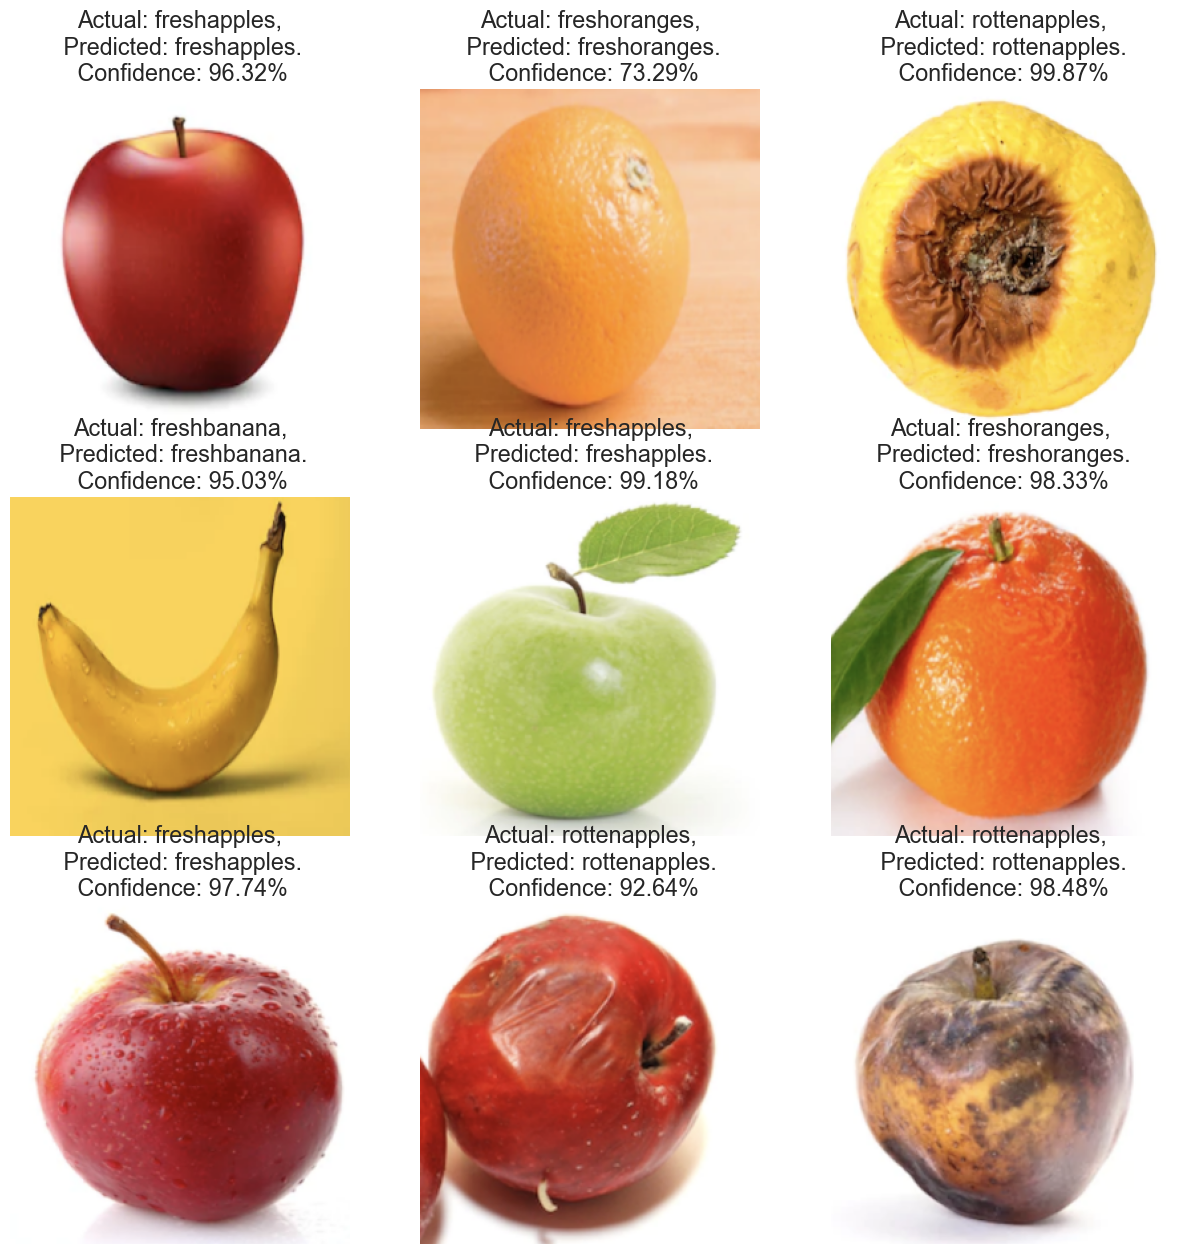

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Testing the model using real life data

Testing model on a rotten orange, and a fresh banana

1/1 [==============================] - 0s 34ms/step


(-0.5, 299.5, 167.5, -0.5)

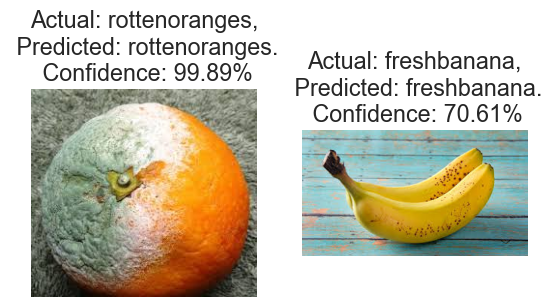

In [56]:
#Real Life Test
image = cv2.imread(os.path.join(os.getcwd(),"orange_real.jpg"))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1)
plt.imshow(image.astype("uint8"))

predicted_class, confidence = predict(model, image)

plt.title(f"Actual: rottenoranges,\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.axis("off")

image = cv2.imread(os.path.join(os.getcwd(),"banana_real.jpg"))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.subplot(1,2,2)
plt.imshow(image.astype("uint8"))

predicted_class, confidence = predict(model, image)

plt.title(f"Actual: freshbanana,\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.axis("off")